In [70]:
# %matplotlib qt
%matplotlib inline

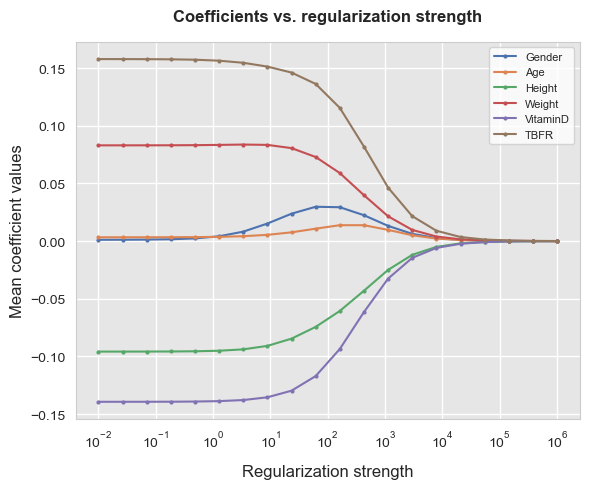

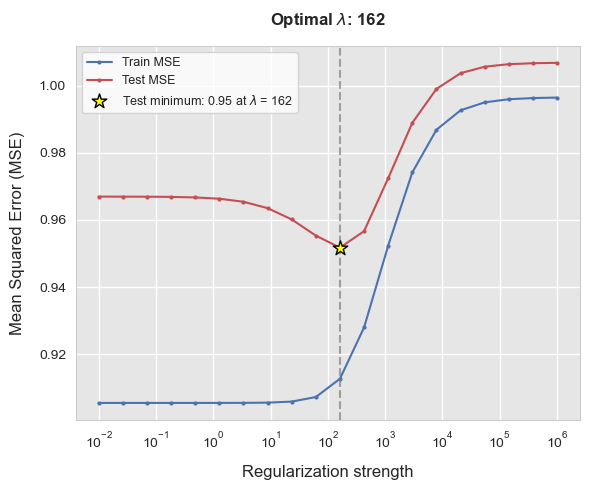

Optimal λ = 162.4


In [20]:
# Imports 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

# Loading data
path = r"C:\Users\mk\OneDrive\Med-tek\Kandidat\1. Semester\Machine Learning\Project1\gallstone_standardized.xlsx"
df = pd.read_excel(path)

# Vælger target = CRP (standardiseret)
target_col = "CRP_std"

# Features = alle *_std kolonner undtagen target_col
all_std_cols = [c for c in df.columns if c.endswith("_std")]
feature_cols = [c for c in all_std_cols if c != target_col]  # fjerner CRP fra X

X_df = df[feature_cols].copy()
y = df[target_col].copy()  # y = CRP_std

# Removing NaNs
mask = X_df.notna().all(axis=1) & y.notna()
X = X_df.loc[mask].values
y = y.loc[mask].values

# Prettier feature names - for the layouts of the plots
pretty_names = [c.replace("_std", "") for c in feature_cols]

# Lambda grid (log scale) + 10-fold CV setup 
lambdas = np.logspace(-2, 6, 20)
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Collect CV metrics and mean coefficients for each λ
mean_train_mse = []
mean_val_mse   = []
mean_coefs_by_lambda = []


# Ridge‐cross-validationen
for lam in lambdas:
    fold_train_mse = []
    fold_val_mse = []
    fold_coefs = []

    for tr_idx, val_idx in kf.split(X):
        X_tr, X_val = X[tr_idx], X[val_idx]
        y_tr, y_val = y[tr_idx], y[val_idx]

        model = Ridge(alpha=lam, fit_intercept=True, random_state=0)
        model.fit(X_tr, y_tr)

        y_tr_hat = model.predict(X_tr)
        y_val_hat = model.predict(X_val)

        fold_train_mse.append(mean_squared_error(y_tr, y_tr_hat))
        fold_val_mse.append(mean_squared_error(y_val, y_val_hat))
        fold_coefs.append(model.coef_)

    mean_train_mse.append(np.mean(fold_train_mse))
    mean_val_mse.append(np.mean(fold_val_mse))
    mean_coefs_by_lambda.append(np.mean(fold_coefs, axis=0))

mean_train_mse = np.array(mean_train_mse)
mean_val_mse   = np.array(mean_val_mse)
mean_coefs_by_lambda = np.vstack(mean_coefs_by_lambda)



# Optimal λ (min validation error)
best_idx = int(np.argmin(mean_val_mse))
best_lambda = lambdas[best_idx]




# Layout for plots
sns.set_style("whitegrid")


# Plot 1: Effect of λ on coefficients
plt.figure(figsize=(6, 5))
ax = plt.gca()
ax.set_facecolor("#e6e6e6")

# Bruger deep palette-farverne
palette = sns.color_palette("deep")
num_colors = len(palette)

for j, name in enumerate(pretty_names):
    color = palette[j % num_colors]  
    ax.plot(lambdas, mean_coefs_by_lambda[:, j], ".-", label=name, color=color, markersize=4)

ax.set_xscale("log")
ax.set_xlabel("Regularization strength", labelpad=10, fontsize=12)
ax.set_ylabel("Mean coefficient values", fontsize=12)
ax.set_title("Coefficients vs. regularization strength", weight="bold", pad=15)
ax.legend(loc="best", fontsize=8)
ax.grid(True, color="white", linewidth=1)

plt.tight_layout()
plt.savefig("ridge_coefficients.png", dpi=300, facecolor="white")
plt.show()


# Plot 2: Training and validation error
plt.figure(figsize=(6, 5))
ax = plt.gca()
ax.set_facecolor("#e6e6e6")

# Farver 
train_color = palette[0]  # blå
test_color = palette[3]   # rød

# Plotter training og validation MSE med 
ax.plot(lambdas, mean_train_mse, ".-", label="Train MSE", color=train_color, markersize=4)
ax.plot(lambdas, mean_val_mse, ".-", label="Test MSE", color=test_color, markersize=4)

# Akseopsætning
ax.set_xscale("log")
ax.set_xlabel("Regularization strength", labelpad=10, fontsize=12)
ax.set_ylabel("Mean Squared Error (MSE)", labelpad=10, fontsize=12)
ax.set_title(
    r"Optimal $\lambda$: {:.0f}".format(float(best_lambda)),
    weight="bold", pad=15,
)
ax.grid(True, color="white", linewidth=1)

mse_min = float(mean_val_mse[best_idx])


# Gul stjerne der markerer minimum test MSE
ax.scatter(
    [best_lambda],
    [mean_val_mse[best_idx]],
    s=120,
    color="yellow",
    marker="*",
    edgecolor="k",
    zorder=5,
    label=fr"Test minimum: {mse_min:.2f} at $\lambda$ = {best_lambda:.0f}",
)

# Lodret linje ved optimal λ
ax.axvline(best_lambda, color="gray", linestyle="--", alpha=0.7)

# Legend
ax.legend(loc="best", fontsize=9)

plt.tight_layout()
plt.savefig("ridge_validation_error.png", dpi=300, facecolor="white")
plt.show()


print(f"Optimal λ = {best_lambda:.4g}")


In [28]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge

# Indlæser data
path = r"C:\Users\mk\OneDrive\Med-tek\Kandidat\1. Semester\Machine Learning\Project1\gallstone_standardized.xlsx"
df = pd.read_excel(path)


# Features = alle _std kolonner undtagen 'CRP_std'
all_std = [c for c in df.columns if isinstance(c, str) and c.endswith('_std')]
features = [c for c in all_std if c.lower() != 'crp_std']

# Target = CRP 
target_col = "C-Reactive Protein (CRP)"

# gør features og target til numeriske numpy arrays
X = df[features].astype(float).values
y = pd.to_numeric(df[target_col], errors='coerce').values

# Removing NaNs
mask = (~pd.isna(y)) & (~np.isnan(X).any(axis=1))
X = X[mask]
y = y[mask]

# Ridge-regression (λ = 162)
ridge = Ridge(alpha=162, fit_intercept=True)
ridge.fit(X, y)

# Print intercept og vægte 
coef_df = pd.DataFrame({"feature": features, "weight": ridge.coef_})
coef_df = coef_df.reindex(coef_df["weight"].abs().sort_values(ascending=False).index)

print(f"\nIntercept (w0): {ridge.intercept_:.6f}")
for _, row in coef_df.iterrows():
    print(f"{row['feature']:<30} : {row['weight']:+.6f}")



Intercept (w0): 1.806445
TBFR_std                       : +0.399559
Height_std                     : -0.235645
Weight_std                     : +0.137473
Age_std                        : -0.123915
VitaminD_std                   : -0.112926
Gender_std                     : +0.096332
